In [1]:
import numpy as np

In [10]:
import scipy.stats as sts
import heapq
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

from collections import deque
import numpy as np

#adapt the code from classes 
class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.
    '''
    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        '''
        This overloads the less-than operator in Python. We need it so the
        priority queue knows how to compare two events. We want events with
        earlier (smaller) times to go first.
        '''
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        Run an event by calling the function with its arguments and keyword
        arguments. The first argument to any event function is always the
        schedule in which events are being tracked. The schedule object can be
        used to add new events to the priority queue.
        '''
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.
    
    The `now` attribute contains the time at which the last event was run.
    '''
    
    def __init__(self):
        self.now = 0  # Keep track of the current simulation time
        self.priority_queue = []  # The priority queue of events to run
    
    def add_event_at(self, timestamp, function, *args, **kwargs):
        # Add an event to the schedule at a particular point in time.
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))
    
    def add_event_after(self, interval, function, *args, **kwargs):
        # Add an event to the schedule after a specified time interval.
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    
    def next_event_time(self):
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        # Get the next event from the priority queue and run it.
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        
    def __repr__(self):
        return (
            f'Schedule() at time {self.now} ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'   {event.timestamp}: {event.function.__name__}')

In [11]:
class TrafficLight: 
    def __init__(self, time_step = 2): 
        """
        Create a traffic light object that can switch lights
        """
        self.traffic_light = '🟢'
        self.time_step = time_step
        
    def run(self, schedule): 
        """
        Start with a green light 

        Parameters
        ----------
        schedule: Schedule
            A schedule object associated with the simulation

        Returns
        ----------
        None   
        """
        if self.traffic_light == '🟢':
            schedule.add_event_after(self.time_step, self.change_to_red)
        else: 
            schedule.add_event_after(self.time_step, self.change_to_green)

    def change_to_red(self, schedule): 
        """
        Schedule a red light 

        Parameters
        ----------
        schedule: Schedule
            A schedule object associated with the simulation

        Returns
        ----------
        None           
        """
        self.traffic_light = '🔴'
        schedule.add_event_after(self.time_step, self.change_to_green)

    def change_to_green(self, schedule): 
        """
        Schedule a green light 
        
        Parameters
        ----------
        schedule: Schedule
            A schedule object associated with the simulation

        Returns
        ----------
        None           
        """        
        self.traffic_light = '🟢'
        schedule.add_event_after(self.time_step, self.change_to_red)


In [12]:
class Road: 
    def __init__(self, road_length, direction, TrafficLight): 

        '''
        Contains all the road

        Parameters
        ----------
        road_length: int 
            Length of the road 
        direction: str 
            Direction of the that the road move toward 
        TrafficLight: object
            Traffic Light object 

        Attributes
        ----------
        road_list: list
            A list for all the positions on the road 
        direction: str 
            Direction of the that the road move toward 
        road_length: int 
            Length of the road 
        next_road: object 
            The next road object of the current road object 
        next_road_intersection_loc: int 
            The intersection location for the next road object 
        prev_road: object 
            The previous road object of the current road object 
        prev_road_intersection_loc: int 
            The intersection location for the previous road object       
        reg_traffic_light_loc: int  
            The traffic light location which a car cannot turn 
        turn_traffic_light_loc: int  
            The traffic light location which a car can turn    
        TrafficLight: object 
            A traffic light object 
        '''
        
        self.road_list = [-1 for _ in range(road_length)]
        self.direction = direction
        self.road_length = road_length
        self.next_road = None 
        self.next_road_intersection_loc = float('inf')
        self.prev_road = None 
        self.prev_road_intersection_loc = float('inf')        
        self.reg_traffic_light_loc = None 
        self.turn_traffic_light_loc = None 
        self.light_object = TrafficLight


    def update_next_road(self, road, intersection): 
        """
        Find the next road of the current road and their intersection 
        
        Parameters
        ----------
        road: object
            Current road 
        intersection: int
            The location of the intersection

        Returns
        ----------
        None           
        """        
        self.next_road = road
        self.next_road_intersection_loc = intersection
    
    def update_prev_road(self, road, intersection): 
        """
        Find the previous road of the current road and their intersection 
        
        Parameters
        ----------
        road: object
            Current road 
        intersection: int
            The location of the intersection

        Returns
        ----------
        None           
        """                
        self.prev_road = road
        self.prev_road_intersection_loc = intersection

    def find_current_intersection(self): 
        """
        Find the current intersecion 
        Parameters
        ----------
        None

        Returns
        ----------
        regular traffic light location, turn traffic light location                

        """
        if self.direction == 'up': 
            return self.reg_traffic_light_loc - 1, self.turn_traffic_light_loc - 1
        if self.direction == 'down': 
            return self.reg_traffic_light_loc + 1, self.turn_traffic_light_loc + 1
        if self.direction == 'left': 
            return self.reg_traffic_light_loc + 1, self.turn_traffic_light_loc + 1
        if self.direction == 'right': 
            return self.reg_traffic_light_loc - 1, self.turn_traffic_light_loc - 1

    def update_traffic_light(self): 
        """
        Update traffic light on the roads
        
        Parameters
        ----------
        None

        Returns
        ----------
        None           
        """                        
        one_light = self.light_object.traffic_light 
        
        if one_light == '🔴': other_light = '🟢'
        else: other_light = '🔴'

        if (self.direction == 'up'): 
            self.turn_traffic_light_loc = 3 + 1
            self.reg_traffic_light_loc = self.road_length - 3
            self.road_list[self.reg_traffic_light_loc] = one_light
            self.road_list[self.turn_traffic_light_loc] = one_light
        if (self.direction == 'right') : 
            self.turn_traffic_light_loc = 3 + 1
            self.reg_traffic_light_loc = self.road_length - 3
            self.road_list[self.reg_traffic_light_loc] = other_light
            self.road_list[self.turn_traffic_light_loc] = other_light
    
        if self.direction == 'left':
            self.reg_traffic_light_loc = 3 - 1
            self.turn_traffic_light_loc = self.road_length - 5 
            self.road_list[self.reg_traffic_light_loc] = other_light
            self.road_list[self.turn_traffic_light_loc] = other_light            
        if self.direction == 'down': 
            self.reg_traffic_light_loc = 3 - 1
            self.turn_traffic_light_loc = self.road_length - 5  
            self.road_list[self.reg_traffic_light_loc] = one_light
            self.road_list[self.turn_traffic_light_loc] = one_light   


In [13]:

class TrafficSimulation: 
    def __init__(self, TrafficLight, car_density, road_length, max_speed, car_turn_prob, prob_slow, system_time_step = 1): 

        '''
        Contains all the road

        Parameters
        ----------
        TrafficLight: object
            Traffic Light object 
        car_density: int 
            Density of the car
        road_length: int 
           Length of the road 
        max_speed: int 
            Maximum speed of the car          
        car_turn_prob: float
            Probability of a car turning
        prob_slow: float
            Probability of a slowing down
        system_time_step: int
            Time to update the system


        Attributes
        ----------
        car_density: int 
            Density of the car
        road_length: int 
           Length of the road 
        v_roads: list
            Vertical roads 
        h_roads: list 
            Horizontal roads
        max_speed: int 
            Maximum speed of the car 
        time_step: int
            Time step counter 
        light_object: object            
            TrafficLight object 
        car_turn_prob: float
            Probability of a car turning
        prob_slow: float
            Probability of a slowing down
        system_time_step: int
            Time to update the system      
        average_traffic_flow: list 
            Average traffic flow for every system update
        state: matrix
            Current state
        '''

        self.car_density = car_density
        self.road_length = road_length
        self.v_roads = [Road(self.road_length, 'up', TrafficLight), Road(self.road_length, 'down', TrafficLight)]
        self.h_roads = [Road(self.road_length, 'left', TrafficLight), Road(self.road_length, 'right', TrafficLight)]
        self.max_speed = max_speed
        self.light_object = TrafficLight
        self.car_turn_prob = car_turn_prob
        self.prob_slow = prob_slow
        self.system_time_step = system_time_step

        # Keep track of the time steps and average traffic flow at each step
        self.time_step = 0
        self.average_traffic_flow = []


       # Create an empty road: -1 means empty in this simulation
        self.state = np.matrix([['▊' for _ in range(self.road_length)] for _ in range(self.road_length)])

        self.place_car_on_road(self.v_roads)
        self.place_car_on_road(self.h_roads)               
        self.place_road_on_grid()


    def place_car_on_road(self, roads): 
        """
        Place car on the road 
        
        Parameters
        ----------
        roads: object
            All the roads

        Returns
        ----------
        None           
        """    
        for road in roads: 
            # Choose random locations to place cars
            random_indexes = np.random.choice(
                range(self.road_length),
                size=int(round(self.car_density * self.road_length)),
                replace=False)

            #no car in the intersection in the beginning 
            intersection = set([3, self.road_length-4])
            random_indexes = list(set(random_indexes) - intersection)

            # Give each car a random initial speed from 0 to max_speed
            for x in random_indexes: 
                speed = np.random.randint(0, self.max_speed)
                road.road_list[x] = speed     
        
   
    def place_road_on_grid(self): 
        """
        Place roads on a 2D grid (the matrix)
        
        Parameters
        ----------
        None

        Returns
        ----------
        None                   
        """    

        roads = self.h_roads + self.v_roads
        h_0 = self.h_roads[0]
        h_1 = self.h_roads[1]
        v_0 = self.v_roads[0]
        v_1 = self.v_roads[1]

        self.add_traffic_light()        

        #connect roads and specify interesections for pevious and next road
        v_0.update_next_road(h_0, 3) #v_0's location 3 is the intersection of the next road 
        h_0.update_next_road(v_1, 3) 
        v_1.update_next_road(h_1, self.road_length-4)
        h_1.update_next_road(v_0, self.road_length-4)        
        v_0.update_prev_road(h_1, 3)
        h_0.update_prev_road(v_0, 3)        
        v_1.update_prev_road(h_0, self.road_length-4)
        h_1.update_prev_road(v_1, self.road_length-4)
        
        #car can turn
        for road in roads: 
            self.car_turn(road)
            # print('⭐️⭐️ after turning new_road', road.direction, road.road_list, sum([1 if (isinstance(ele, int) and ele >=0) else 0 for ele in road.road_list]))

        # add roads on 2D grid
        self.state[3] = h_0.road_list
        self.state[-4] = h_1.road_list
        self.state[:, 3] = np.reshape(v_0.road_list, (self.road_length, 1))
        self.state[:, -4] = np.reshape(v_1.road_list, (self.road_length, 1)) 
        self.fix_intersection_display(h_0, v_0, h_1, v_1)

    def fix_intersection_display(self, h_0, v_0, h_1, v_1): 
        """
        Fix the intersection point display
        
        Parameters
        ----------
        h_0: object 
            A horizontal road with direction going left 
        v_0: object
            A vertical road with direction going up         
        h_1: object
            A horizontal road with direction going right        
        v_1: object 
            A vertical road with direction going down
        Returns
        ----------
        None                            
        """
        #piece the right intersection - prevent intersection on h_roads get covered
        #pair up index of the same intersection on two roads (use global location)
        left_up_h0, left_up_v0 = h_0.reg_traffic_light_loc + 1, v_0.turn_traffic_light_loc - 1
        right_up_h0, right_up_v1 = h_0.turn_traffic_light_loc + 1, v_1.reg_traffic_light_loc + 1
        right_down_h1, right_down_v1= h_1.reg_traffic_light_loc - 1, v_1.turn_traffic_light_loc + 1
        left_down_h1, left_down_v0= h_1.turn_traffic_light_loc - 1, v_0.reg_traffic_light_loc - 1

        if h_0.road_list[left_up_h0] != -1: 
            self.state[left_up_h0, left_up_v0] = h_0.road_list[left_up_h0]

        if h_0.road_list[right_up_h0] != -1:
            self.state[right_up_h0, right_up_v1] = h_0.road_list[right_up_h0]

        if h_1.road_list[right_down_h1] != -1:
            self.state[right_down_h1, right_down_v1] = h_1.road_list[right_down_h1]

        if h_1.road_list[left_down_h1] != -1:
            self.state[left_down_h1, left_down_v0] = h_1.road_list[left_down_h1]
    
        
    def car_turn(self, road): 
        """
        Car turn on a road 
        
        Parameters
        ----------
        road: object
            Current road 

        Returns
        ----------
        None                            
        """        
        if road.direction == 'left': 
            turn_intersection_loc = road.road_length - road.turn_traffic_light_loc + 1
            new_turn_intersection_loc = road.road_length - turn_intersection_loc - 1
        elif road.direction == 'down':
            turn_intersection_loc = road.turn_traffic_light_loc + 1
            new_turn_intersection_loc = road.road_length - road.turn_traffic_light_loc + 1
        elif road.direction == 'up':
            turn_intersection_loc = road.turn_traffic_light_loc - 1
            new_turn_intersection_loc = turn_intersection_loc
        elif road.direction == 'right': 
            turn_intersection_loc = road.turn_traffic_light_loc - 1
            new_turn_intersection_loc = road.road_length - road.turn_traffic_light_loc 
        
        #if car is on a intersection 
        if road.road_list[turn_intersection_loc] != -1: 
            if random.random() <= self.car_turn_prob:
                #empty the car and put it on the next road    
                cur_car_speed = road.road_list[turn_intersection_loc]
                # print('⭐ ⭐ From road', road.direction, 'turn_intersection_loc', turn_intersection_loc, 'to road', road.next_road.direction, 'new_turn_intersection_loc',new_turn_intersection_loc, 'with a speed', cur_car_speed)
                
                road.road_list[turn_intersection_loc] =  -1
                
                road.next_road.road_list[new_turn_intersection_loc]= cur_car_speed

    def add_traffic_light(self): 

        """
        Add traffic light 
        
        Parameters
        ----------
        None 

        Returns
        ----------
        None                            
        """        
        
        #update traffic light location on the road 
        roads = self.v_roads + self.h_roads
        for road in roads:
            road.update_traffic_light()
    
    def update_system(self, schedule):     

        """
        Update the entire traffic system 
        
        Parameters
        ----------
        schedule: Schedule
            A schedule object associated with the simulation

        Returns
        ----------
        None                            
        """        

        roads = self.h_roads + self.v_roads
        self.v_roads = []
        self.h_roads = []
        for road in roads:
            # print('⭐️⭐️  road list', road.direction, road.road_list, sum([1 if (isinstance(ele, int) and ele >=0) else 0 for ele in road.road_list])

            # Reverse road list the car flow direction
            if (road.direction == 'up') or (road.direction == 'right'): 
                road.road_list.reverse()

            for i in range(len(road.road_list)): 
                car = road.road_list[i]

            
                #if it's a traffic light 
                if (car == '🔴') or (car == '🟢'): 
                    pass

                #if it's a car, not an empty road 
                elif car != -1:
                    self.update_car(car, i, road)
            
            
            #move the car 
            new_road = Road(self.road_length, road.direction, self.light_object)

            for i in range(self.road_length):
                cell = road.road_list[i] 
                
                #if a car 
                if cell != -1 and (cell != '🔴') and (cell != '🟢') :
                    new_loc = (i + cell) % self.road_length 

                    #if the loc was a green light, don't step on it, move back one cell. 
                    if road.road_list[new_loc] == '🟢':
                            new_road.road_list[(i + cell -1) % self.road_length] = cell
                    else: 
                        new_road.road_list[new_loc] = cell            
            
            #reverse the list back
            if (new_road.direction == 'up') or (new_road.direction == 'right'): 
                new_road.road_list.reverse()

            #put the new road in the road lists 
            if (new_road.direction == 'up') or (new_road.direction == 'down'): 
                self.v_roads.append(new_road)
            else: 
                self.h_roads.append(new_road)
            # print('⭐️ new_road', new_road.direction, new_road.road_list)

        #Put the road back to the grid  
        self.state = np.matrix([['▊' for _ in range(self.road_length)] for _ in range(self.road_length)])
        
        self.place_road_on_grid()
        
        #Update average traffic flow history
        ttl_traffic_flow = 0
        for road in roads: 
            ttl_traffic_flow += sum([ele if (isinstance(ele, int) and ele >0) else 0 for ele in road.road_list])
        avg_traffic = ttl_traffic_flow/ (self.road_length*4-4) #average 4 roads
        self.average_traffic_flow.append(avg_traffic)
        self.time_step += 1
        
        schedule.add_event_after(self.system_time_step, self.update_system)



    def update_car(self, car, i, road): 

        """
        Update the car location
        
        Parameters
        ----------
        car: int 
            Speed of a car 
        i: int 
            Current location of a car
        road: object
            Current road where the car is on      

        Returns
        ----------
        None                            
        """              
        # Distance is the number of empty cells between this car and the
        # next car plus 1
        distance = 1
        
        #if empty or green light and no car on the interesection 
        while (road.road_list[(i + distance) % road.road_length] == -1) \
        or (road.road_list[(i + distance) % road.road_length] == '🟢'):
            
            # check if there is a car on a intersection 
            if ((i + distance) % road.road_length) == road.find_current_intersection()[0]:
                if road.prev_road.road_list[road.prev_road_intersection_loc] != -1: 
                    break                                            
            if ((i + distance) % road.road_length) == road.find_current_intersection()[1]:
                if road.next_road.road_list[road.next_road_intersection_loc] != -1: 
                    break
            distance += 1
        
        # Acceleration
        if road.road_list[i] < self.max_speed:
            road.road_list[i] += 1
        # Deceleration
        if road.road_list[i] >= distance:
            road.road_list[i] = distance - 1
        #Randomization
        if (
            (road.road_list[i] > 0) and
            (np.random.uniform() < self.prob_slow) #probability of slow 
        ):
            road.road_list[i] -= 1    


    def run(self, schedule): 
        """
        Update the entire traffic system 
        
        Parameters
        ----------
        schedule: Schedule
            A schedule object associated with the simulation

        Returns
        ----------
        None                            
        """                    
        schedule.add_event_after(2, self.update_system)

## Code testing: no turning and no slowing down

- Traffic light: change color for every 2 time steps
- System: update every time step

In [16]:
traffic_light = TrafficLight()
schedule = Schedule()
traffic_light.run(schedule)
car_density = 0.5
road_length = 10
max_speed = 5 
car_turn_prob = 0
prob_slow = 0 

sim = TrafficSimulation(traffic_light, car_density, road_length, max_speed, car_turn_prob, prob_slow)
sim.run(schedule)
print("Initial state")
print(sim.state)

while schedule.next_event_time() < 7:
    schedule.run_next_event()
    print()
    print(sim.state)


Initial state
[['▊' '▊' '▊' '-' '▊' '▊' '-' '▊' '▊' '▊']
 ['▊' '▊' '▊' '2' '▊' '▊' '-' '▊' '▊' '▊']
 ['▊' '▊' '▊' '-' '▊' '▊' '🟢' '▊' '▊' '▊']
 ['4' '0' '🔴' '-' '-' '🔴' '-' '4' '-' '2']
 ['▊' '▊' '▊' '🟢' '▊' '▊' '4' '▊' '▊' '▊']
 ['▊' '▊' '▊' '2' '▊' '▊' '🟢' '▊' '▊' '▊']
 ['0' '1' '-' '-' '🔴' '3' '-' '🔴' '-' '-']
 ['▊' '▊' '▊' '🟢' '▊' '▊' '-' '▊' '▊' '▊']
 ['▊' '▊' '▊' '1' '▊' '▊' '-' '▊' '▊' '▊']
 ['▊' '▊' '▊' '4' '▊' '▊' '-' '▊' '▊' '▊']]

[['▊' '▊' '▊' '-' '▊' '▊' '-' '▊' '▊' '▊']
 ['▊' '▊' '▊' '2' '▊' '▊' '-' '▊' '▊' '▊']
 ['▊' '▊' '▊' '-' '▊' '▊' '🟢' '▊' '▊' '▊']
 ['4' '0' '🔴' '-' '-' '🔴' '-' '4' '-' '2']
 ['▊' '▊' '▊' '🟢' '▊' '▊' '4' '▊' '▊' '▊']
 ['▊' '▊' '▊' '2' '▊' '▊' '🟢' '▊' '▊' '▊']
 ['0' '1' '-' '-' '🔴' '3' '-' '🔴' '-' '-']
 ['▊' '▊' '▊' '🟢' '▊' '▊' '-' '▊' '▊' '▊']
 ['▊' '▊' '▊' '1' '▊' '▊' '-' '▊' '▊' '▊']
 ['▊' '▊' '▊' '4' '▊' '▊' '-' '▊' '▊' '▊']]

[['▊' '▊' '▊' '1' '▊' '▊' '-' '▊' '▊' '▊']
 ['▊' '▊' '▊' '-' '▊' '▊' '-' '▊' '▊' '▊']
 ['▊' '▊' '▊' '3' '▊' '▊' '🔴' '▊' '▊

## Code testing for turning function: always turning but no slowing down

(Note: Feel free to use the print function with ⭐️ to test the code.)

In [20]:
traffic_light = TrafficLight()
schedule = Schedule()
traffic_light.run(schedule)
car_density = 0.5
road_length = 10 
max_speed = 5 
car_turn_prob = 1
prob_slow = 0 

sim = TrafficSimulation(traffic_light, car_density, road_length, max_speed, car_turn_prob, prob_slow)
sim.run(schedule)
while schedule.next_event_time() < 7:
    schedule.run_next_event()
    print()
    print(sim.state)
    # print("car count", sum([1 if ele.isdigit() else 0 for x in sim.state.tolist() for ele in x]))


[['▊' '▊' '▊' '0' '▊' '▊' '0' '▊' '▊' '▊']
 ['▊' '▊' '▊' '-' '▊' '▊' '-' '▊' '▊' '▊']
 ['▊' '▊' '▊' '-' '▊' '▊' '🟢' '▊' '▊' '▊']
 ['3' '0' '🔴' '-' '-' '🔴' '-' '-' '-' '-']
 ['▊' '▊' '▊' '🟢' '▊' '▊' '0' '▊' '▊' '▊']
 ['▊' '▊' '▊' '2' '▊' '▊' '🟢' '▊' '▊' '▊']
 ['1' '-' '-' '-' '🔴' '-' '-' '🔴' '3' '1']
 ['▊' '▊' '▊' '🟢' '▊' '▊' '3' '▊' '▊' '▊']
 ['▊' '▊' '▊' '3' '▊' '▊' '2' '▊' '▊' '▊']
 ['▊' '▊' '▊' '0' '▊' '▊' '1' '▊' '▊' '▊']]

[['▊' '▊' '▊' '0' '▊' '▊' '-' '▊' '▊' '▊']
 ['▊' '▊' '▊' '-' '▊' '▊' '1' '▊' '▊' '▊']
 ['▊' '▊' '▊' '3' '▊' '▊' '🔴' '▊' '▊' '▊']
 ['0' '0' '🟢' '-' '-' '🟢' '-' '-' '-' '-']
 ['▊' '▊' '▊' '🔴' '▊' '▊' '1' '▊' '▊' '▊']
 ['▊' '▊' '▊' '-' '▊' '▊' '🔴' '▊' '▊' '▊']
 ['0' '-' '-' '2' '🟢' '-' '-' '🟢' '0' '0']
 ['▊' '▊' '▊' '🔴' '▊' '▊' '0' '▊' '▊' '▊']
 ['▊' '▊' '▊' '-' '▊' '▊' '0' '▊' '▊' '▊']
 ['▊' '▊' '▊' '0' '▊' '▊' '0' '▊' '▊' '▊']]

[['▊' '▊' '▊' '0' '▊' '▊' '1' '▊' '▊' '▊']
 ['▊' '▊' '▊' '1' '▊' '▊' '0' '▊' '▊' '▊']
 ['▊' '▊' '▊' '-' '▊' '▊' '🔴' '▊' '▊' '▊']
 ['0' 

# Run experinments

## Average traffic flow over different density

In [208]:
# Run the simulation 200 times at various traffic densities from 0 to 1 and
# record the results. The maximum speed is 5 and the probability of slowing
# down is 0.2.

trials = 20 # Number of times to repeat the simulation at each density
densities = np.linspace(0, 1, 101)
average_flows = []  # The results go here


def experiments(trials, densities, average_flows): 
    for density in densities:
        flows = []
        for trial in range(trials):
            traffic_time_step = 50
            traffic_light = TrafficLight(traffic_time_step)
            schedule = Schedule()
            traffic_light.run(schedule)
            sim = TrafficSimulation(traffic_light, 
            car_density = density, 
            road_length = 100, 
            max_speed = 5, 
            car_turn_prob = 0.5, 
            prob_slow = 0.2)

            sim.run(schedule)
            
            # Run for 50 steps to reach an equilibrium state
            while schedule.next_event_time() < 50:
                schedule.run_next_event()

            # Record the final average traffic flow
            flows.append(sim.average_traffic_flow[-1])
        average_flows.append(flows)
    average_flows = np.array(average_flows)
    return average_flows

average_flows = experiments(trials, densities, average_flows)    

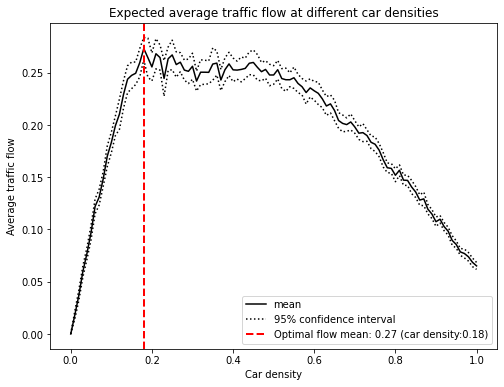

In [222]:
import matplotlib.pyplot as plt
import scipy.stats as sts

plt.figure(figsize=(8, 6))
plt.title('Expected average traffic flow at different car densities')
plt.xlabel('Car density')
plt.ylabel('Average traffic flow')
flow_mean = np.mean(average_flows, axis=1)
std_err = sts.sem(average_flows, axis=1)
plt.plot(densities, flow_mean, 'k-', label='mean')
plt.plot(densities, flow_mean - 1.96 * std_err, 'k:',
         label='95% confidence interval')
plt.plot(densities, flow_mean + 1.96 * std_err, 'k:')
plt.axvline(x=densities[flow_mean.argmax()], color='red', ls='--', lw=2, label=f'Optimal flow mean: {round(flow_mean.max(),2)} (car density:{round(densities[flow_mean.argmax()],2)})')
plt.legend()
plt.show()

## Compare with MFA theoretical results

In [234]:
def mfa(v, density, p_slow):
    '''
    Calculate the updated distribution over speeds given the current
    distribution by applying the MFA traffic rules.

    Inputs:
    
        v (list of float) The car speed probability vector. v[i] is the
        probability that a car is moving at speed i.

        density (float) The average number of cars per cell on the road.
        
        p_slow (float) The probability of random slow-down.
    
    Returns: A new, updated car speed probability vector.
    '''
    v_max = len(v) - 1
    new_v = [0] * len(v)  # The updated speed probability vector
    
    # Probability of a car appearing in front of you
    car_probabilities = [density] * (v_max + 1)
    car_probabilities = [None] + [
        (1-density)**(distance-1) * density for distance in range(1, v_max + 1)]
    car_probabilities.append(1 - np.sum(car_probabilities[1:]))
    
    for v_from in range(v_max + 1):
        
        # Current speed, will be updated below
        speed = v_from
        
        # Accelerate
        if speed < v_max:
            speed += 1
        
        # Brake when there is a car in front at each distance from 1 to speed
        for distance in range(1, speed + 1):
            # Probability that a car is in front at a particular distance
            car_at_distance = car_probabilities[distance]
            if distance > 1:
                new_v[distance-1] += v[v_from] * car_at_distance * (1-p_slow)
                new_v[distance-2] += v[v_from] * car_at_distance * p_slow
            else:
                new_v[distance-1] += v[v_from] * car_at_distance
        
        # No cars in front up to distance == speed
        no_cars = 1 - np.sum(car_probabilities[1:speed+1])
        new_v[speed] += v[v_from] * no_cars * (1-p_slow)
        new_v[speed-1] += v[v_from] * no_cars * p_slow
        
    return new_v

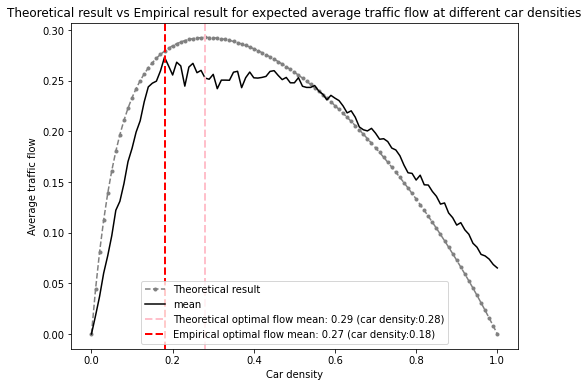

In [253]:
def average_speed(v):
    return np.sum(np.array(v) * np.arange(len(v)))

def average_flow(v, density):
    return density * average_speed(v)

max_speed = 5
p_slow = 0.2
densities = np.linspace(0, 1, 101)

mfa_flow_results = []  # map from p_slow to flow results for all densities


for density in densities:
    # Start from a uniform distribution over speeds
    v = [1/(max_speed + 1)] * (max_speed + 1)
    assert abs(sum(v) - 1) < 1e-6  # Sanity check before
    for i in range(100):  # Run until convergence
        v = mfa(v, density, p_slow)
        assert abs(sum(v) - 1) < 1e-6  # Sanity check after
    mfa_flow_results.append(average_flow(v, density))
mfa_flow_results = np.array(mfa_flow_results)
plt.figure(figsize=(8, 6))
plt.plot(densities, mfa_flow_results, label = 'Theoretical result', marker='.', linestyle='--', color = 'grey')
plt.plot(densities, flow_mean, 'k-', label='mean')
plt.axvline(x=densities[mfa_flow_results.argmax()], color='pink', ls='--', lw=2, label=f'Theoretical optimal flow mean: {round(mfa_flow_results.max(),2)} (car density:{round(densities[mfa_flow_results.argmax()],2)})')
plt.axvline(x=densities[flow_mean.argmax()], color='red', ls='--', lw=2, label=f'Empirical optimal flow mean: {round(flow_mean.max(),2)} (car density:{round(densities[flow_mean.argmax()],2)})')
plt.title('Theoretical result vs Empirical result for expected average traffic flow at different car densities')
plt.xlabel('Car density')
plt.ylabel('Average traffic flow')
plt.legend()
plt.show()

## Average traffic flow over different traffic light duration

In [23]:
traffic_time_steps = np.linspace(20, 120, 5)
trials = 20
average_flows = []
for traffic_time_step in traffic_time_steps:
    flows = []
    for trial in range(trials):
        traffic_time_step = traffic_time_step
        traffic_light = TrafficLight(traffic_time_step)
        schedule = Schedule()
        traffic_light.run(schedule)
        sim = TrafficSimulation(traffic_light, 
        car_density = 0.18, 
        road_length = 100, 
        max_speed = 5, 
        car_turn_prob = 0.5, 
        prob_slow = 0.2)

        sim.run(schedule)
        
        # Run for 50 steps to reach an equilibrium state
        while schedule.next_event_time() < 50:
            schedule.run_next_event()

        # Record the final average traffic flow
        flows.append(sim.average_traffic_flow[-1])
    average_flows.append(flows)
average_flows = np.array(average_flows)

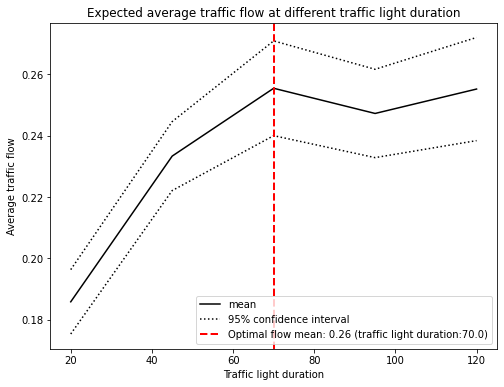

In [28]:
plt.figure(figsize=(8, 6))
plt.title('Expected average traffic flow at different traffic light duration')
plt.xlabel('Traffic light duration')
plt.ylabel('Average traffic flow')
flow_mean = np.mean(average_flows, axis=1)
std_err = sts.sem(average_flows, axis=1)

plt.plot(traffic_time_steps, flow_mean, 'k-', label='mean')
plt.plot(traffic_time_steps, flow_mean - 1.96 * std_err, 'k:',
         label='95% confidence interval')
plt.plot(traffic_time_steps, flow_mean + 1.96 * std_err, 'k:')
plt.axvline(x=traffic_time_steps[flow_mean.argmax()], color='red', ls='--', lw=2, label=f'Optimal flow mean: {round(flow_mean.max(),2)} (traffic light duration:{round(traffic_time_steps[flow_mean.argmax()],2)})')
plt.legend()
plt.show()

## Average traffic flow over different densities and traffic light duration

In [31]:
# Run the simulation 20 times at various traffic densities from 0 to 1 and record the results. The maximum speed is 5 and the probability of slowing
# down is 0.2.

trials = 20 # Number of times to repeat the simulation at each density
densities = np.linspace(0, 1, 51)
average_flows = []  # The results go here


for traffic_time_step in traffic_time_steps:
    for density in densities:
        flows = []
        for trial in range(trials):
            traffic_time_step = traffic_time_step
            traffic_light = TrafficLight(traffic_time_step)
            schedule = Schedule()
            traffic_light.run(schedule)
            sim = TrafficSimulation(traffic_light, 
            car_density = density, 
            road_length = 100, 
            max_speed = 5, 
            car_turn_prob = 0.5, 
            prob_slow = 0.2)

            sim.run(schedule)
            
            # Run for 50 steps to reach an equilibrium state
            while schedule.next_event_time() < 50:
                schedule.run_next_event()

            # Record the final average traffic flow
            flows.append(sim.average_traffic_flow[-1])
        average_flows.append(flows)
average_flows = np.array(average_flows)

In [51]:
flow_mean = np.mean(average_flows, axis=1)
std_err = sts.sem(average_flows, axis=1)

flow_mean= flow_mean.reshape(5, 51)


/var/folders/0h/xyv81g2n7sj6zr0c9cw30gkc0000gn/T/ipykernel_5329/3899419244.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


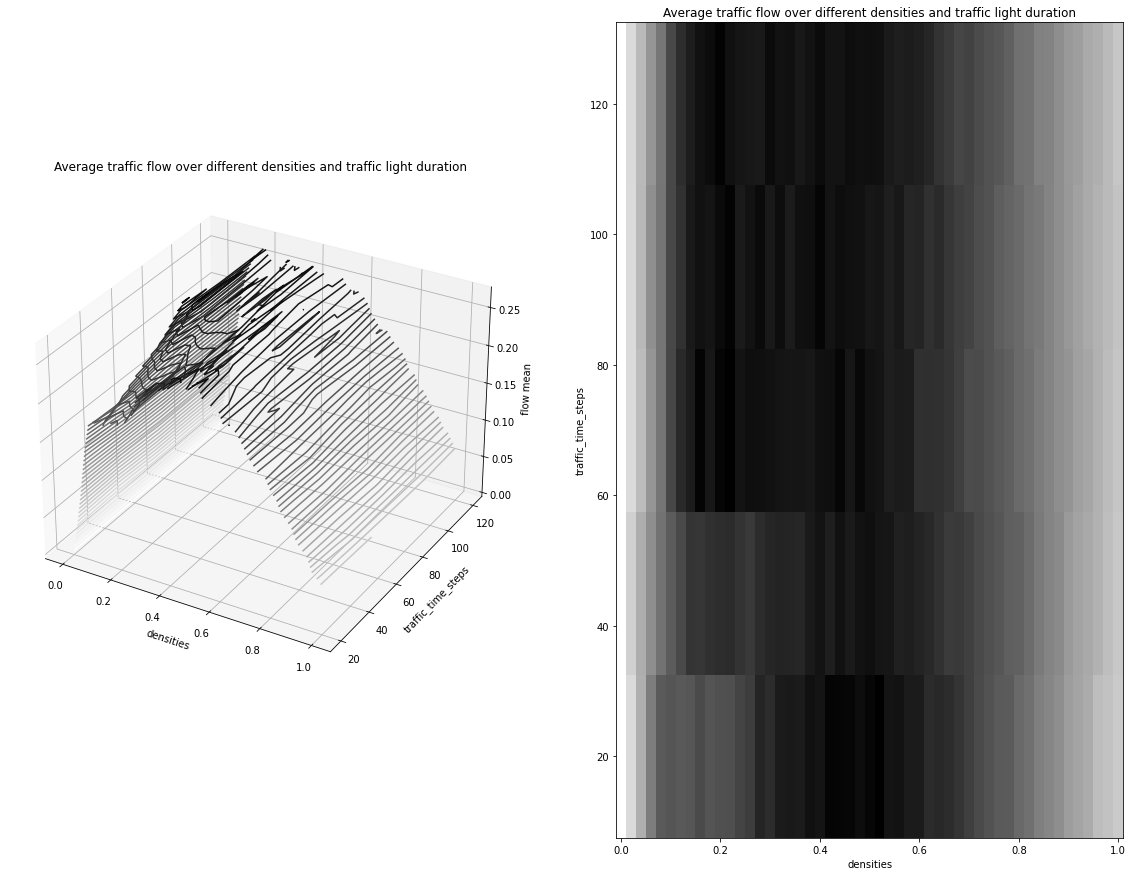

In [56]:
# Plot the results. Make a 2-dimensional plot since we are varying 2 input parameters.
fig = plt.figure(figsize = (20, 15))
ax1 = fig.add_subplot(1, 2, 1, projection = '3d')
ax1.contour3D(densities, traffic_time_steps, flow_mean, 50, cmap = 'binary')
ax1.set_xlabel("densities")
ax1.set_ylabel("traffic_time_steps")
ax1.set_zlabel("flow mean")
ax1.set_title("Average traffic flow over different densities and traffic light duration")

ax2 = fig.add_subplot(1, 2, 2)
ax2.pcolormesh(densities, traffic_time_steps, flow_mean, cmap = plt.cm.binary)
ax2.set_xlabel("densities")
ax2.set_ylabel("traffic_time_steps")
ax2.set_title("Average traffic flow over different densities and traffic light duration")


fig.show()

In [67]:
print(f'The max traffic flow mean is {round(flow_mean.max(),2)}')

The max traffic flow mean is 0.27
